In [1]:
# Constants

months_list = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 
               'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']
invalid_value = -999
data_timezone = 'America/Sao_Paulo'

In [240]:
# Imports

import os
import math

from datetime import timezone, datetime, timedelta

import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
import contextily
import xarray
import datashader

from geopy import distance
from geopy.point import Point

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as colors
import matplotlib.patches as patches
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')

In [3]:
# caches
orbital_cache = {}

In [4]:
# Get all csv files in the burn_folder

directory = os.getcwd()
burn_folder = os.path.join(directory, "data")
csv_files = os.listdir(burn_folder)

print("Reading {} files...".format(len(csv_files)))

column_types = {
    'precipitacao': 'float32',
    'riscofogo': 'float32',
    'latitude': 'float64',
    'longitude': 'float64',
    'frp': 'float64'
}

# Create the DataFrame from csv
df: pd.DataFrame = pd.concat(
    [pd.read_csv(os.path.join(burn_folder, f), parse_dates=["datahora"], dtype=column_types) for f in csv_files], 
    ignore_index=True
  )

# optimize data and setup types
print("Optimizing dataframe {}...".format(df.shape))
df['diasemchuva'] = df['diasemchuva'].fillna(invalid_value).astype("int16")
df.loc[df.riscofogo == invalid_value, 'riscofogo'] = 0
df['riscofogo'] = df['riscofogo'].fillna(0).astype("bool")
df['satelite'] = df['satelite'].str.upper().astype("category")
df['pais'] = df['pais'].str.upper().astype("category")
df['estado'] = df['estado'].str.upper().astype("category")
df['municipio'] = df['municipio'].str.upper().astype("category")
df['bioma'] = df['bioma'].str.upper().astype("category")

print('Data frame optimized with final size: {}'.format(df.memory_usage(deep=True).sum()))

print('Setting up date columns...')
df['datahora'] = df['datahora'].dt.tz_localize(timezone.utc).dt.tz_convert(data_timezone)

df.info()

Reading 300 files...
Optimizing dataframe (43782758, 12)...
Data frame optimized with final size: 1970726633
Setting up date columns...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43782758 entries, 0 to 43782757
Data columns (total 12 columns):
 #   Column        Dtype                            
---  ------        -----                            
 0   datahora      datetime64[ns, America/Sao_Paulo]
 1   satelite      category                         
 2   pais          category                         
 3   estado        category                         
 4   municipio     category                         
 5   bioma         category                         
 6   diasemchuva   int16                            
 7   precipitacao  float32                          
 8   riscofogo     bool                             
 9   latitude      float64                          
 10  longitude     float64                          
 11  frp           float64                          
dtypes:

In [153]:
# Processamento dos satelites

# Vamos remover os satélites TRMM e ATSR porque temos poucos dados e poucas informações



# Muitos satélites podem ser simplificados
satelite_map = {
  'NPP-375D': 'Suomi NPP',
  'NPP-375': 'Suomi NPP',
  'AQUA_M-T': 'AQUA',
  'AQUA_M-M': 'AQUA',
  'AQUA_M': 'AQUA',
  'TERRA_M-T': 'TERRA',
  'TERRA_M-M': 'TERRA',
  'TERRA_M': 'TERRA',
  'NOAA-18D': 'NOAA-18',
  'NOAA-19D': 'NOAA-19',
  'NOAA-16N': 'NOAA-16',
  'NOAA-15D': 'NOAA-15',
  'NOAA-12D': 'NOAA-12'
}
df['simp_satelite'] = df['satelite'].map(satelite_map).fillna(df['satelite']).astype("category")

# cada satélite tem um sensor
satelite_sensors = {
  'Suomi NPP': 'VIIRS',
  'NOAA-20': 'VIIRS',
  'GOES-16': 'ABI',
  'GOES-13': 'GOES I-M',
  'GOES-12': 'GOES I-M',
  'GOES-10': 'GOES I-M',
  'GOES-08': 'GOES I-M',
  'AQUA': 'MODIS',
  'TERRA': 'MODIS',
  'NOAA-18': 'AVHRR-3',
  'NOAA-19': 'AVHRR-3',
  'NOAA-17': 'AVHRR-3',
  'NOAA-16': 'AVHRR-3',
  'NOAA-15': 'AVHRR-3',
  'NOAA-14': 'AVHRR',
  'NOAA-12': 'AVHRR',
  'MSG-03': 'SEVIRI', 
  'MSG-02': 'SEVIRI',
  'METOP-B': 'AVHRR-3', 
  'METOP-C': 'AVHRR-3',
  'ATSR': 'ATSR',
  'TRMM': 'VIRS'
}

df['sensor'] = df['simp_satelite'].map(satelite_sensors).astype("category")

# resolution of all sensors in km
resolution_map = { 
    'VIIRS': 0.5,
    'AVHRR-3': 1.1,
    'MODIS': 1.0,
    'VIRS': 2.0,
    'AVHRR': 1.1,
    'ABI': 2.0,
    'SEVIRI': 3.0,
    'GOES I-M': 4.0
}

In [6]:
# variaveis derivadas dos dados
all_satellites = df['satelite'].value_counts().index.values
simp_satellites = df['simp_satelite'].value_counts().index.values
actual_satellites = df[(df['datahora'].dt.year == 2022)]['simp_satelite'].value_counts().loc[lambda x : x > 0].index.values

print('Original satellites size:', len(all_satellites.tolist()))
print('Simplified satellites size:', len(simp_satellites.tolist()))

Original satellites size: 32
Simplified satellites size: 22


In [22]:
from matplotlib.patches import Rectangle

def plot_colortable(colors, *, ncols=4) -> plt.Figure:
    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

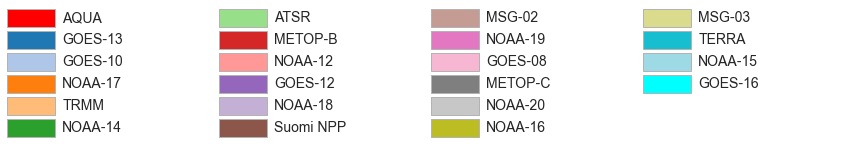

In [8]:
# Escolher cores boas paras os satélites ajuda na análise
# Ai sempre vamos usar as mesmas cores, criando gráficos 
# consistentes entre sí

import random

random.seed(43)

simp_satellites_rand = simp_satellites.tolist()
random.shuffle(simp_satellites_rand)
cmap = plt.cm.get_cmap('tab20', len(simp_satellites_rand))
satellites_colors = {}
for (i, satelite) in enumerate(simp_satellites_rand):
    satellites_colors[satelite] = cmap(i)

satellites_colors[simp_satellites_rand[0]] = (1.0, 0.0, 0.0, 1.0)
satellites_colors[simp_satellites_rand[-1]] = (0.0, 1.0, 1.0, 1.0)

plot_colortable(satellites_colors)
plt.show()

In [9]:
# Pastas dos shapes
aux_folder = os.path.join(directory, "aux")
uf_folder = os.path.join(aux_folder, "ibge/BR_UF_2021")
municipios_folder = os.path.join(aux_folder, "ibge/BR_Municipios_2021")
biomas_folder = os.path.join(aux_folder, "ibge/Biomas_250mil")

estados_shape: gpd.GeoDataFrame = gpd.read_file(uf_folder + '/BR_UF_2021.shp')
municipios_shape: gpd.GeoDataFrame = gpd.read_file(municipios_folder + '/BR_Municipios_2021.shp')
biomas_shape: gpd.GeoDataFrame = gpd.read_file(biomas_folder + '/lm_bioma_250.shp')

# processamento para ser compatível com os dados do INPE
estados_shape['NM_UF'] = estados_shape['NM_UF'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
municipios_shape['NM_MUN'] = municipios_shape['NM_MUN'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
biomas_shape['Bioma'] = biomas_shape['Bioma'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

# falta as áreas dos estados no dado do ibge, bora garimpar elas
estados_shape = pd.merge(
    left=estados_shape,
    right=municipios_shape.groupby(['SIGLA'])['AREA_KM2'].sum(),
    left_on=['SIGLA'],
    right_on=['SIGLA']
)

# dados do ibge também https://brasilemsintese.ibge.gov.br/territorio.html
biomas_shape['AREA_KM2'] = biomas_shape['Bioma'].map({
    'Amazonia': 4196943,
    "Cerrado": 2036448,
    "Mata Atlantica": 1110182,
    "Caatinga": 844453,
    "Pampa": 176496,
    "Pantanal": 150355
})

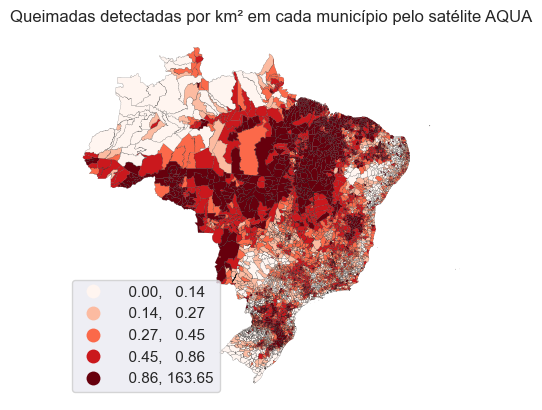

In [162]:
reference_df = df[(df.satelite == 'AQUA_M-T')]
municipios_counts = reference_df.groupby(['municipio'])['municipio'].count().rename('count').to_frame()
municipios_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=municipios_counts,
        right=municipios_shape,
        left_on=['municipio'],
        right_on=['NM_MUN'],
        how='inner'
    )
)

municipios_counts_with_shape['count_by_km2'] = municipios_counts_with_shape['count'] / municipios_counts_with_shape['AREA_KM2']

ax = municipios_counts_with_shape.plot(
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
ax.set_title(u'Queimadas detectadas por km\u00b2 em cada município pelo satélite AQUA')
ax.set_axis_off()

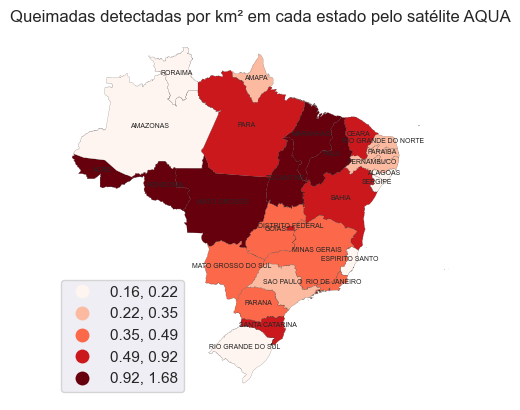

In [163]:
reference_df = df[(df.satelite == 'AQUA_M-T')]
estados_counts = reference_df.groupby(['estado'])['estado'].count().rename('count').to_frame()
estado_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=estados_counts,
        right=estados_shape,
        left_on=['estado'],
        right_on=['NM_UF'],
        how='inner'
    )
)

estado_counts_with_shape['count_by_km2'] = estado_counts_with_shape['count'] / estado_counts_with_shape['AREA_KM2']

ax = estado_counts_with_shape.plot(
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
estado_counts_with_shape.apply(
    lambda x: ax.annotate(text=x['NM_UF'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=5), 
    axis=1
)

ax.set_title(u'Queimadas detectadas por km\u00b2 em cada estado pelo satélite AQUA')
ax.set_axis_off()

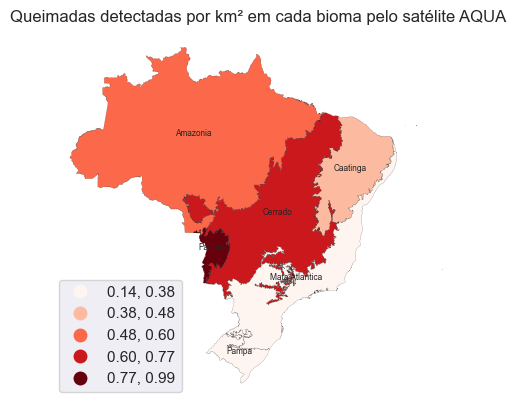

In [161]:
reference_df = df[(df.satelite == 'AQUA_M-T')]
bioma_counts = reference_df.groupby(['bioma'])['bioma'].count().rename('count').to_frame()
bioma_counts_with_shape = gpd.GeoDataFrame(
    pd.merge(
        left=bioma_counts,
        right=biomas_shape,
        left_on=['bioma'],
        right_on=['Bioma'],
        how='inner'
    )
)

bioma_counts_with_shape['count_by_km2'] = bioma_counts_with_shape['count'] / bioma_counts_with_shape['AREA_KM2']

ax = bioma_counts_with_shape.plot(
    column='count_by_km2',
    scheme="Quantiles",
    cmap="Reds",
    edgecolor="k",
    linewidth=0.1,
    legend=True,
    legend_kwds={'loc': 'lower left'}
)
bioma_counts_with_shape.apply(
    lambda x: ax.annotate(text=x['Bioma'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), 
    axis=1
)
ax.set_title(u'Queimadas detectadas por km\u00b2 em cada bioma pelo satélite AQUA')
ax.set_axis_off()

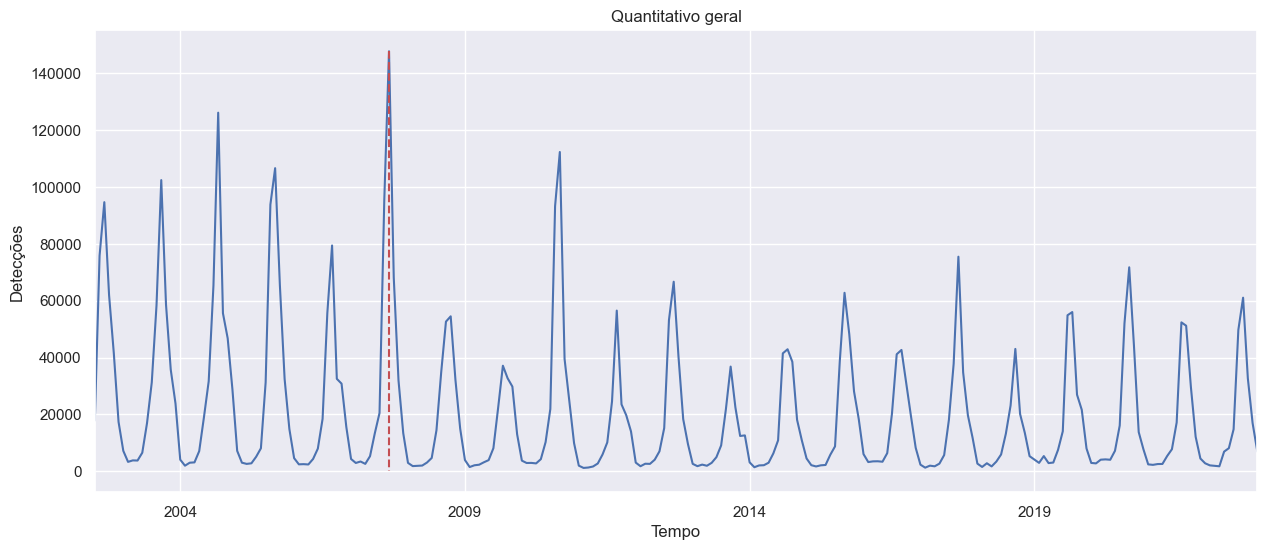

In [201]:
# analise quantitativa dos dados com relacao a flag risco de fogo
reference_df = df[(df.satelite == 'AQUA_M-T')]

date_sem_risco_counts = reference_df.groupby([reference_df['datahora'].dt.date])['datahora'].count()

daily_df = date_sem_risco_counts.fillna(0).astype('int')
daily_df.index = pd.to_datetime(daily_df.index)
# daily_df['Total'] = daily_df.iloc[:, 0] + daily_df.iloc[:, 1]
weekly_df = daily_df.resample('M').sum()

fig, ax = plt.subplots(1, 1, figsize=(15,6))
weekly_df.plot(ax=ax, title='Quantitativo geral')
ax.set_xlabel('Tempo')
ax.set_ylabel('Detecções')
ax.vlines(weekly_df.idxmax(), weekly_df.max(), 0, color='r', linestyles='--')

# a, b = np.polyfit(weekly_df.index, weekly_df.values, 1)
# plt.plot(weekly_df.values, a*weekly_df.values+b, ax=ax)    

# weekly_df.loc['2021'].plot(y='Total', ax=axs[1], title='Quantitativo de ano de 2021')

In [ ]:
def bar_limited(serie: pd.Series, ax: plt.Axes=plt.axes(), min_percent=0.02, title: str='', xlabel: str='', ylabel: str=''):
    pie_temp = serie.loc[lambda x : x > 0]
    total = pie_temp.sum()
    greatter = pie_temp.loc[lambda x : x/total >= min_percent].map(lambda x : x/total * 100)
    little = pie_temp.loc[lambda x : x/total < min_percent]
    print('outros:', little)
    pd.concat([greatter, pd.Series(data=[little.sum()/total * 100], index=['Outros'])]).plot.bar(
        y='Detecções',
        ax=ax,
        title=title
    )
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

outros: NOAA-15    863266
GOES-13    605870
NOAA-16    599411
METOP-B    338016
GOES-10    290127
MSG-03     280700
MSG-02     205509
ATSR       148199
TRMM        90204
METOP-C     58131
NOAA-17     55451
GOES-08     42081
NOAA-14     31069
Name: simp_satelite, dtype: int64
outros: NOAA-19    64491
NOAA-18    41782
MSG-03     18175
METOP-B     8072
METOP-C     5467
Name: simp_satelite, dtype: int64


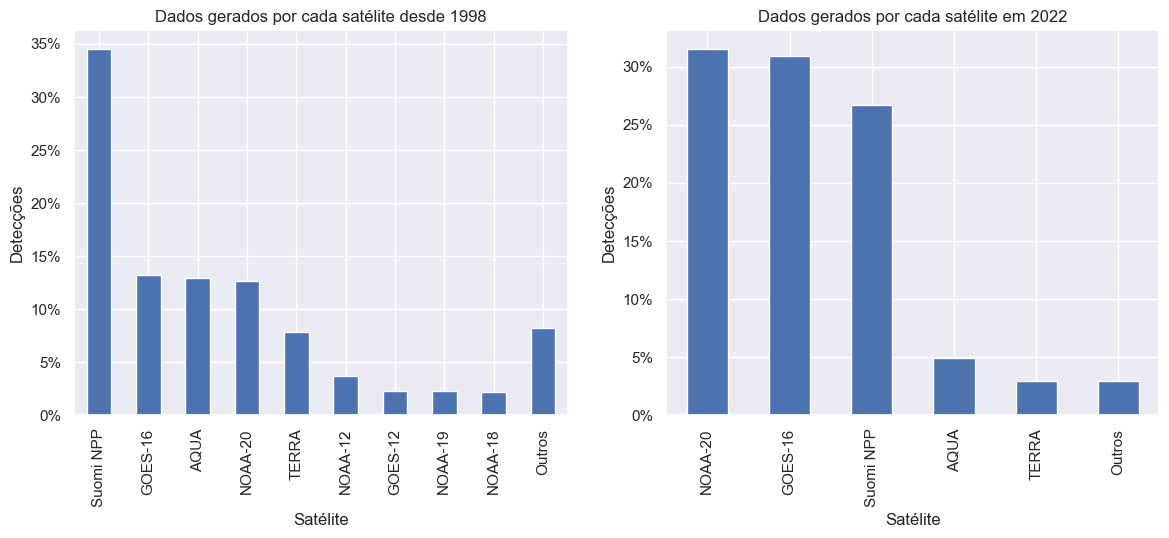

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

bar_limited(
    df["simp_satelite"].value_counts(),
    ax=axs[0],
    title='Dados gerados por cada satélite desde 1998',
    xlabel='Satélite',
    ylabel='Detecções'
)

bar_limited(
    df[(df['datahora'].dt.year == 2022)]["simp_satelite"].value_counts(),
    ax=axs[1],
    title='Dados gerados por cada satélite em 2022',
    xlabel='Satélite',
    ylabel='Detecções'
)

outros: SEVIRI    486209
ATSR      148199
VIRS       90204
Name: sensor, dtype: int64
outros: SEVIRI    18175
Name: sensor, dtype: int64


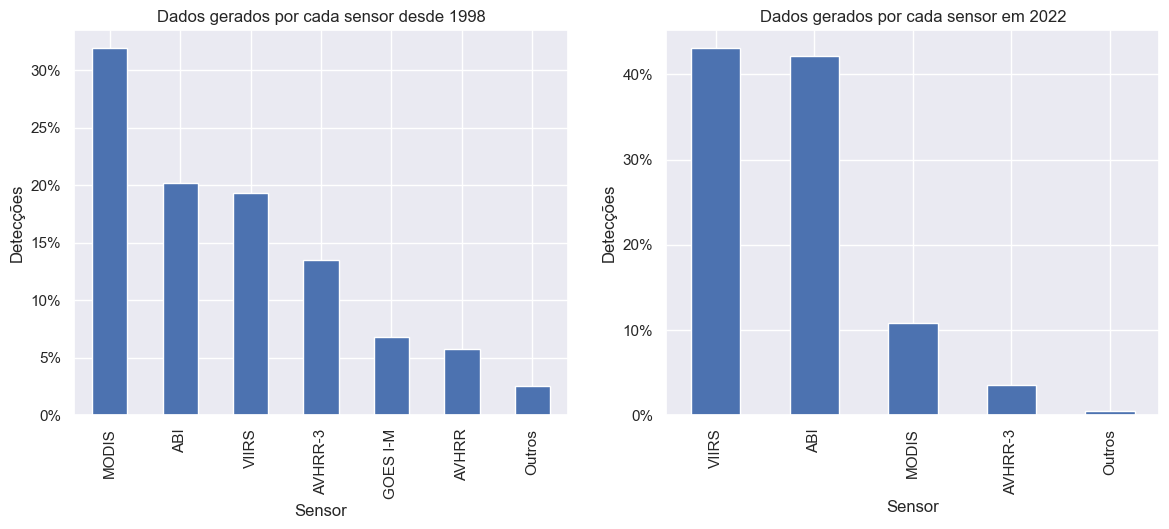

In [222]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

bar_limited(
    df["sensor"].value_counts(),
    ax=axs[0],
    title='Dados gerados por cada sensor desde 1998',
    xlabel='Sensor',
    ylabel='Detecções'
)

bar_limited(
    df[(df['datahora'].dt.year == 2022)]["sensor"].value_counts(),
    ax=axs[1],
    title='Dados gerados por cada sensor em 2022',
    xlabel='Sensor',
    ylabel='Detecções'
)

Text(0.5, 0, 'Horário')

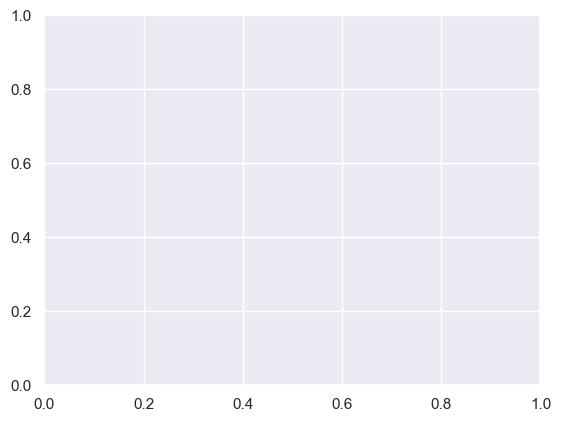

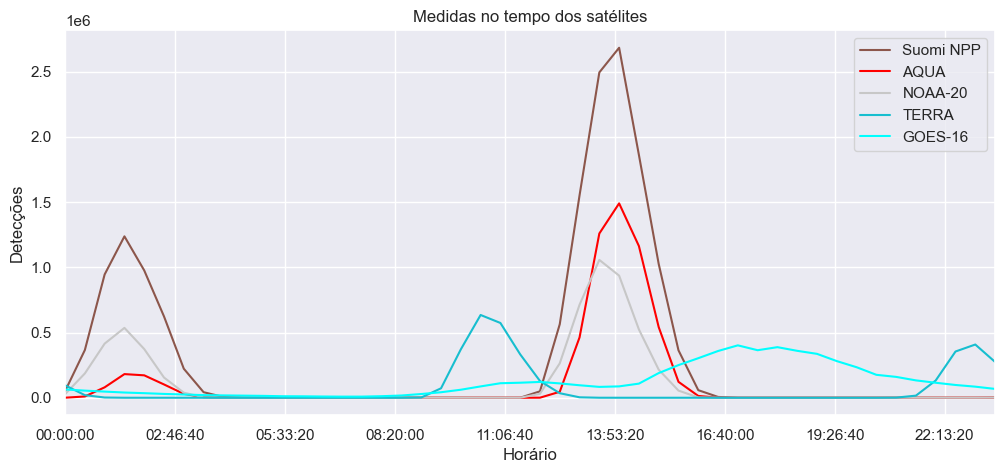

In [208]:
# analise do horários das medicoes dos satelites
def time_measure_dist(satelite='AQUA_M-T', ax: plt.Axes=plt.axes()):
  filtered_df = df[(df["simp_satelite"] == satelite)]
  time_counts = filtered_df.groupby([filtered_df['datahora'].dt.time])['datahora'].count()
  time_counts.index = pd.TimedeltaIndex(data=time_counts.index.astype('str'))
  
  if '00:00:00' not in time_counts.index:
    time_counts['00:00:00'] = 0
  if '23:59:59' not in time_counts.index:
    time_counts['23:59:59'] = 0
  time_counts = time_counts.resample('30min').sum().reindex().rename(satelite)
  time_counts.plot(ax=ax, c=satellites_colors[satelite], legend=True)

time_satellites = ['Suomi NPP', 'AQUA', 'NOAA-20', 'TERRA', 'GOES-16']
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for satelite in time_satellites:
  time_measure_dist(satelite, ax)

ax.set_title("Medidas no tempo dos satélites")
ax.set_ylabel('Detecções')
ax.set_xlabel('Horário')

In [232]:
import requests

requests.get("https://sips.ssec.wisc.edu/api/v1/products/search.sh?products=VNP02MOD&satellite=snpp").text

'#!/usr/bin/env sh\n# NASA VIIRS Atmosphere SIPS, UW SSEC\n# http://sips.ssec.wisc.edu\n# Status: success\n# Code: 200\n# Message: \n# Results: 0\n# Fields: url\nxargs -t -n1 -P4 curl -sO <<EOF\nEOF\n'

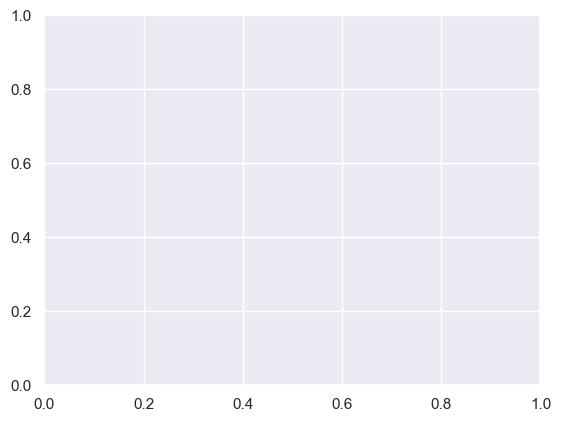

In [53]:
from pyorbital.orbital import Orbital

def get_orbital(satelite: str) -> Orbital:
    global orbital_cache
    if satelite not in orbital_cache.keys():
        orbital_cache[satelite] = Orbital(satelite)
    return orbital_cache[satelite]

def draw_orbit(range: pd.DatetimeIndex, satelite: str, title: str = "", color = None, ax: plt.Axes=plt.axes()):
    orb = get_orbital(satelite)
    data = pd.DataFrame(index=pd.to_datetime(range, utc=True))
    positions = data.index.map(orb.get_lonlatalt)
    data['longitude'] = positions.map(lambda x: x[0])
    data['latitude'] = positions.map(lambda x: x[1])
    if color is None:
        ax.plot(data['longitude'], data['latitude'], '-x', linewidth=1, markersize=5, label=satelite)
    else:
        ax.plot(data['longitude'], data['latitude'], '-x', linewidth=1, markersize=5, label=satelite, color=color)
        
    ax.legend(loc="lower left")
    ax.set_xlim([-85, -35])
    ax.set_ylim([-35, 5])
    ax.set_title(title)
    for index in [data.index[3], data.index[-3]]:
        ax.annotate(index.strftime("%H:%M"), (data['longitude'][index], data['latitude'][index]))



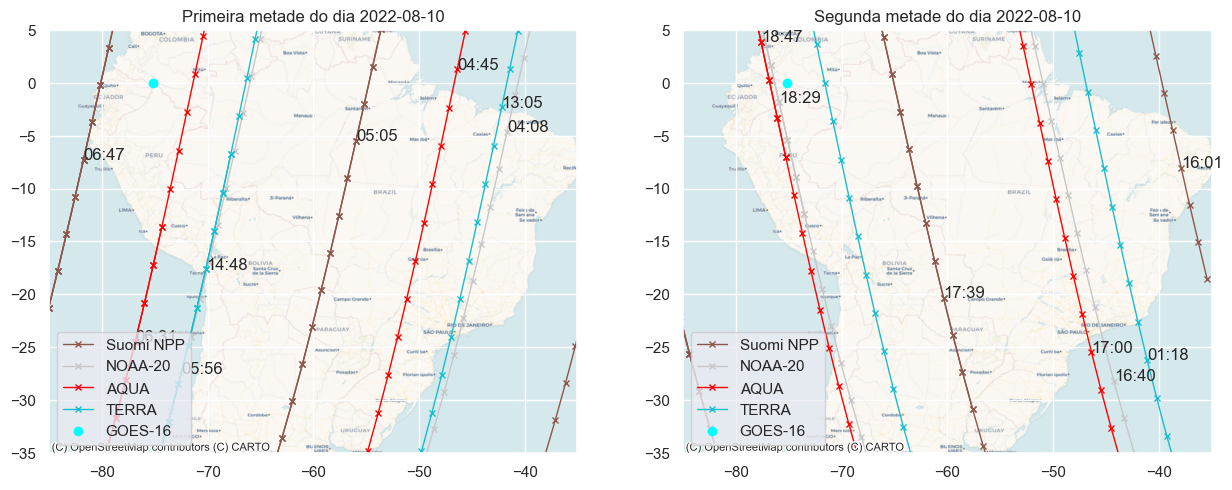

In [418]:

fig, axs=plt.subplots(1, 2, figsize=(15, 8))
day = "2022-08-10"
names = {
    "Suomi NPP": ["{} {}".format(day, "03:44"), "{} {}".format(day, "02:02"), "{} {}".format(day, "00:20")],
    "NOAA-20": ["{} {}".format(day, "02:53"), "{} {}".format(day, "01:05")],
    "AQUA": ["{} {}".format(day, "03:28"), "{} {}".format(day, "01:42")],
    "TERRA": ["{} {}".format(day, "11:45"), "{} {}".format(day, "10:02")],
}

names2 = {
    "Suomi NPP": ["{} {}".format(day, "14:36"), "{} {}".format(day, "16:17"), "{} {}".format(day, "12:58")],
    "NOAA-20": ["{} {}".format(day, "15:26"), "{} {}".format(day, "13:37")],
    "AQUA": ["{} {}".format(day, "13:57"), "{} {}".format(day, "15:44")],
    "TERRA": ["{} {}".format(day, "01:03"), "{} {}".format(day, "22:15")],
}

for (key, value) in names.items():
    for time in value:
        draw_orbit(
            range=pd.date_range(time, freq=timedelta(minutes=1), periods=300, tz=data_timezone),
            satelite=key,
            title="Primeira metade do dia {}".format(day),
            color=satellites_colors[key],
            ax=axs[0]
        )

for (key, value) in names2.items():
    for time in value:
        draw_orbit(
            range=pd.date_range(time, freq=timedelta(minutes=1), periods=300, tz=data_timezone),
            satelite=key,
            title="Segunda metade do dia {}".format(day),
            color=satellites_colors[key],
            ax=axs[1]
        )

# draw geostationary
axs[0].plot(-75.190, 0.0, 'o', color=satellites_colors['GOES-16'], label='GOES-16')
axs[1].plot(-75.190, 0.0, 'o', color=satellites_colors['GOES-16'], label='GOES-16')

handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[0].legend(by_label.values(), by_label.keys(), loc="lower left")

handles, labels = axs[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs[1].legend(by_label.values(), by_label.keys(), loc="lower left")

contextily.add_basemap(
    axs[0], 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Voyager,
)

contextily.add_basemap(
    axs[1], 
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.Voyager,
)

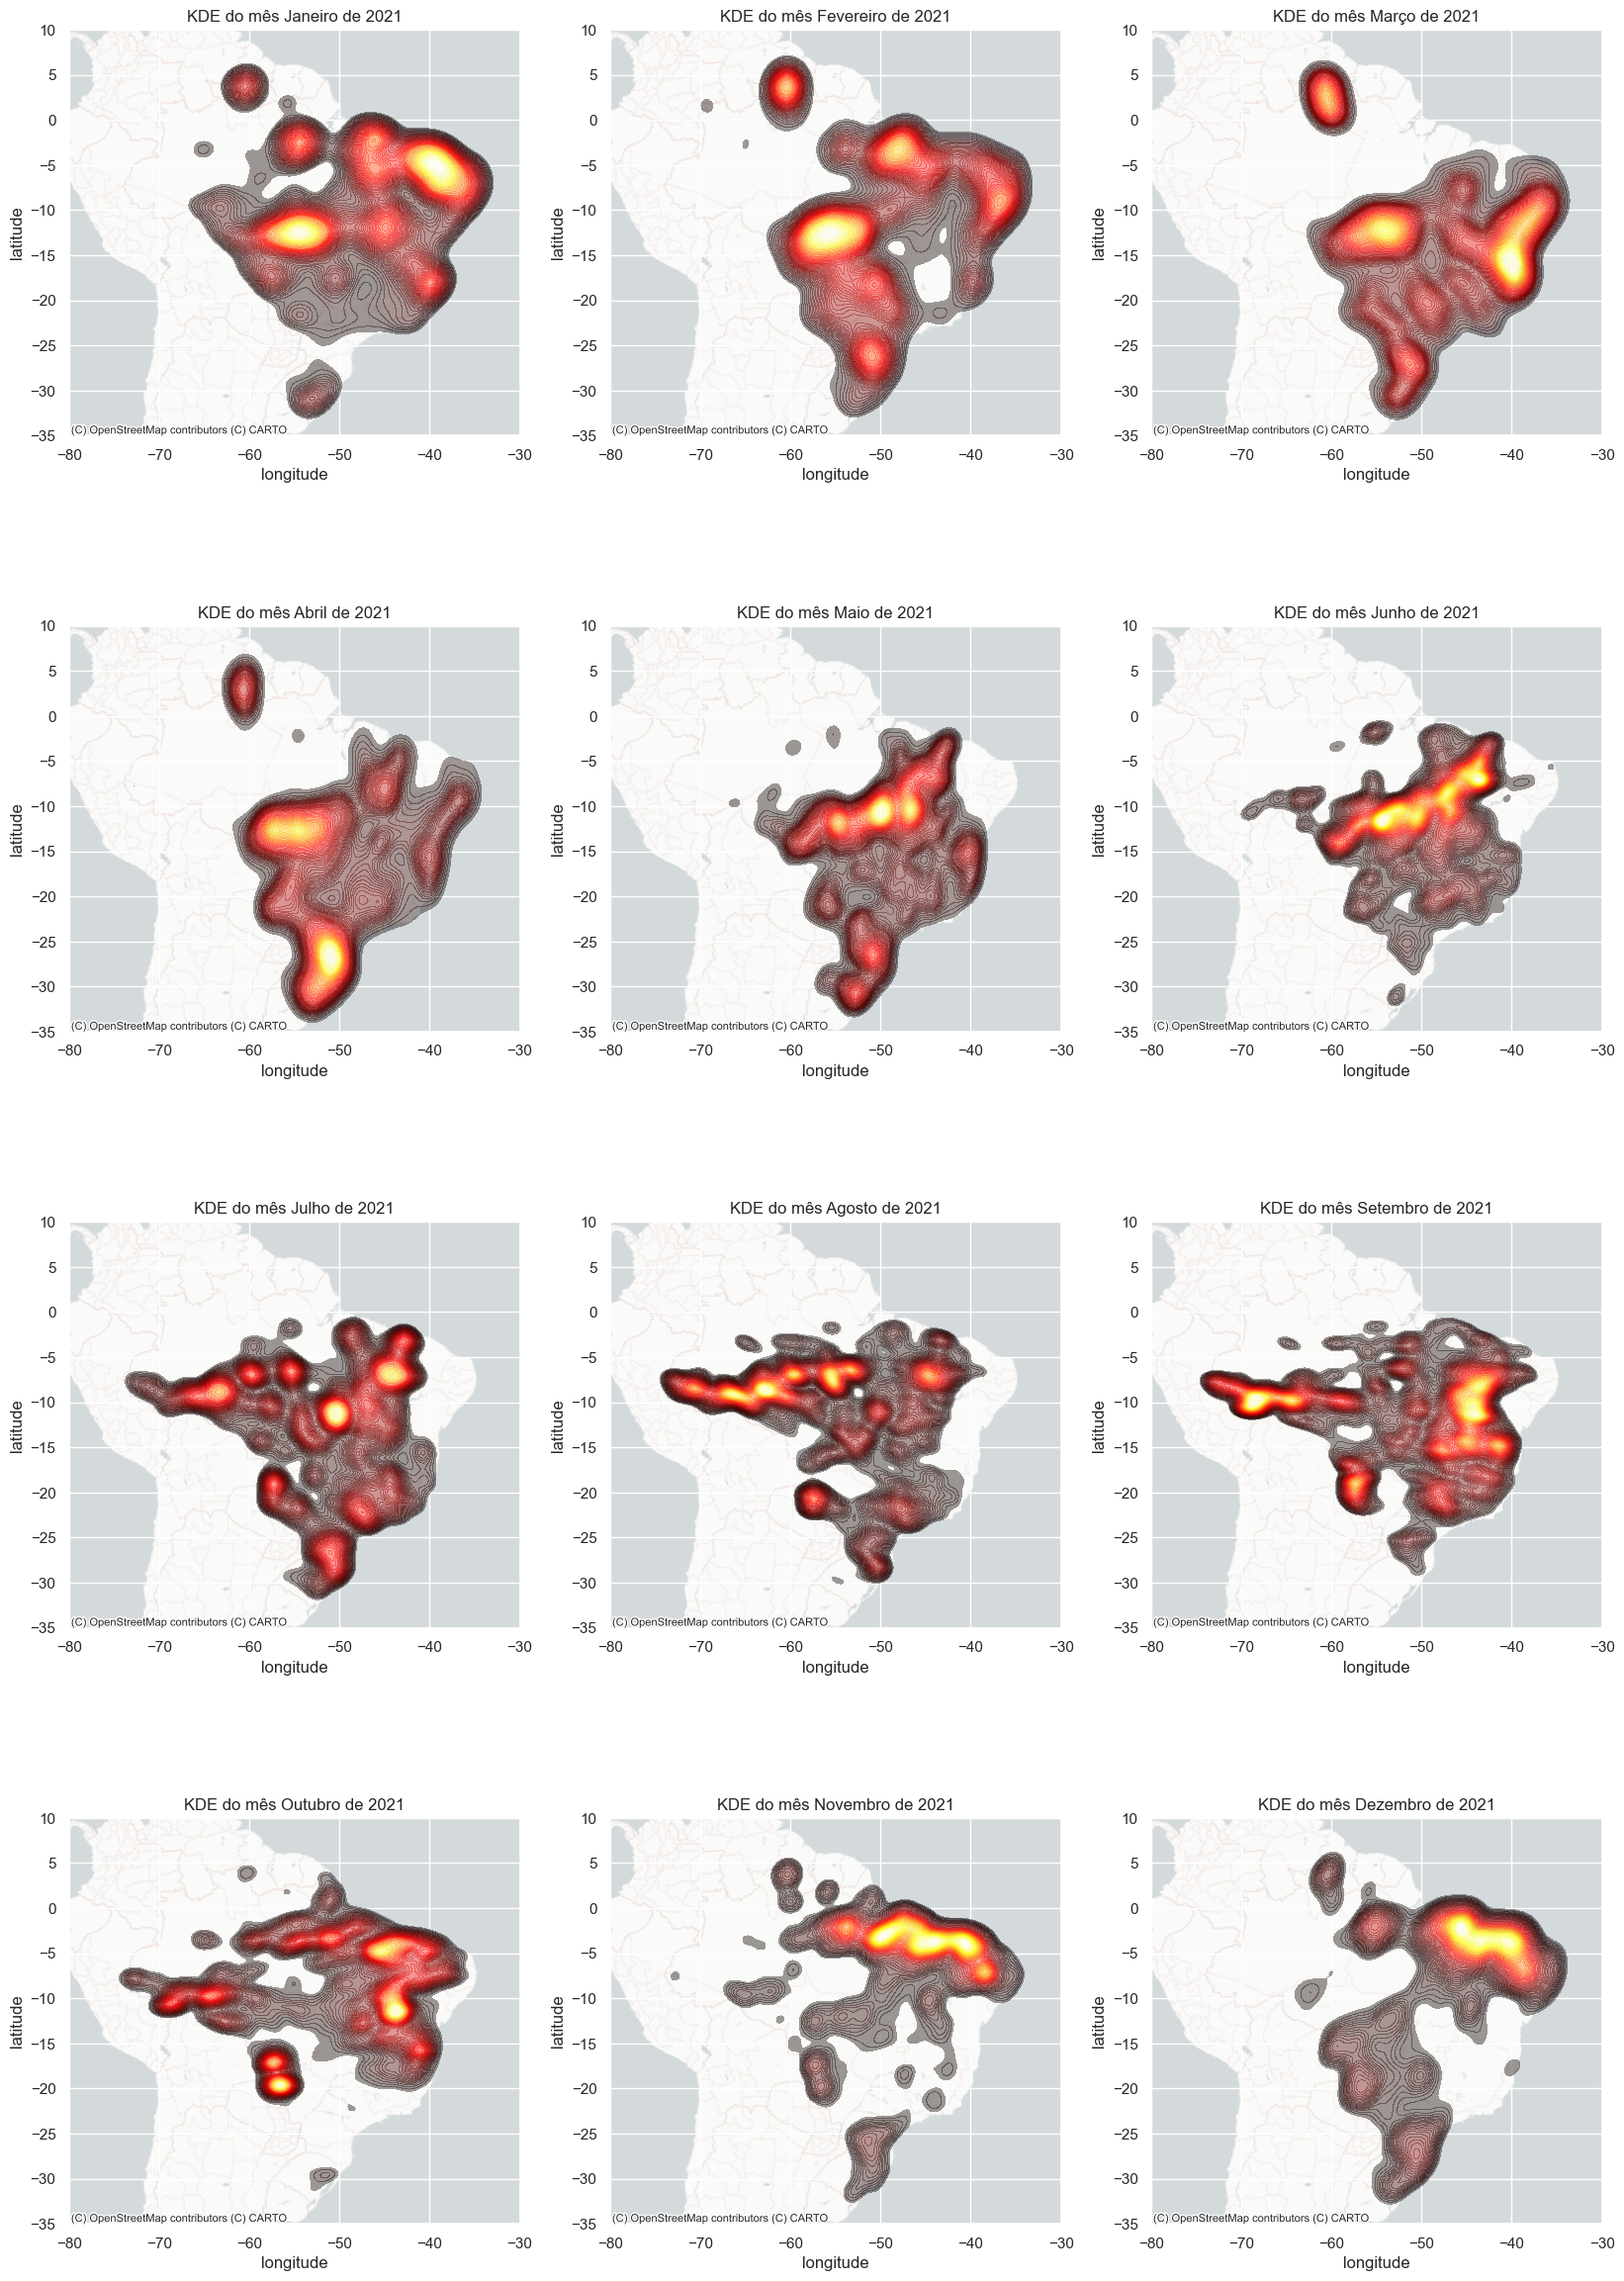

In [8]:
fig, axs = plt.subplots(4, 3, figsize=(20, 30))
year = 2021
for i, ax in enumerate(axs.flat):
  month = i+1
  temp_df = reference_df.query('mes == {} and ano == {}'.format(month, year))
  ax.set_xlim([-80, -30])
  ax.set_ylim([-35, 10])
  sns.kdeplot(
      x=temp_df.longitude,
      y=temp_df.latitude,
      n_levels=50,
      fill=True,
      alpha=0.40,
      cmap="hot",
      bw_adjust=0.6,
      #cbar=True,
      ax=ax
  )
  ax.set_title("KDE do mês {} de {}".format(months_list[i], year))
  contextily.add_basemap(
      ax, 
      crs="EPSG:4326",
      source=contextily.providers.CartoDB.PositronNoLabels,
  )


In [466]:
# Utils functions

def sub_space(data: pd.DataFrame, min_lat: float, max_lat: float, min_lon: float, max_lon: float) -> pd.DataFrame:
    """Returns a sub data filtered by lat and lon boundary"""
    return data.query('@min_lon <= longitude <= @max_lon & @min_lat <= latitude <= @max_lat')

def split_by_range(data: pd.DataFrame, range: pd.DatetimeIndex, time_column='datahora') -> list[pd.DataFrame]:
    """Returns a list of dataframe with time_column grouped for each value of range"""
    list = []
    if len(range) <= 1:
        return list
    for (i, current) in enumerate(range):
        if i < len(range) - 2:
            next = range[i+1]
            list.append(data[(data[time_column] >= current) & (data[time_column] < next)])
    return list

def grid_to_dataframe(grid: xarray.DataArray) -> pd.DataFrame:
    data = grid.to_pandas().unstack()
    frame =  data.where(data > 0).dropna().reset_index().rename(columns={0: "value"}) 
    return frame

def compute_grid(data: pd.DataFrame, min_lat: float = None, max_lat: float = None, 
                 min_lon: float = None, max_lon: float = None, 
                 aggr_dist = distance.Distance(kilometers=1)) -> xarray.DataArray:
    if not min_lat:
        min_lat = data['latitude'].min()
    if not max_lat:
        max_lat = data['latitude'].max()
    if not min_lon:
        min_lon = data['longitude'].min()
    if not max_lon:
        max_lon = data['longitude'].max()

     # calculate the grid (agregate)
    width_bottom = distance.distance((min_lat, min_lon), (min_lat, max_lon))
    width_top = distance.distance((max_lat, min_lon), (max_lat, max_lon))

    height_left = distance.distance((min_lat, min_lon), (max_lat, min_lon))
    height_right = distance.distance((min_lat, max_lon), (max_lat, max_lon))

    width = max(width_top, width_bottom)
    height = max(height_left, height_right)

    cvs = datashader.Canvas(
        plot_width=int(width/aggr_dist), 
        plot_height=int(height/aggr_dist),
        x_range=(min_lon, max_lon),
        y_range=(min_lat, max_lat)
    )
    return cvs.points(data, x="longitude", y="latitude")

In [291]:
import math


class AltAzimuthRange(object):
    default_lat = None
    default_long = None
    default_elv = None

    def __init__(self):
        if AltAzimuthRange.default_lat and AltAzimuthRange.default_long and AltAzimuthRange.default_elv:
            self.a = {'lat': AltAzimuthRange.default_lat, 'lon': AltAzimuthRange.default_long,
                      'elv': AltAzimuthRange.default_elv}
        else:
            self.a = None
        self.b = None
        pass

    def observer(self, lat: float, long: float, altitude: float):
        # latitude, longitude, meters above sea level (can be lower than zero)
        self.a = {'lat': lat, 'lon': long, 'elv': altitude}

    def target(self, lat: float, long: float, altitude: float):
        # latitude, longitude, meters above sea level (can be lower than zero)
        self.b = {'lat': lat, 'lon': long, 'elv': altitude}

    def calculate(self) -> dict:
        if not self.a:
            raise Exception(
                "Observer is not defined. Fix this by using instance_name.observer(lat,long,altitude) method")
        if not self.b:
            raise Exception(
                "Target location is not defined. Fix this by using instance_name.target(lat,long,altitude) method")
        ap, bp = AltAzimuthRange.LocationToPoint(self.a), AltAzimuthRange.LocationToPoint(self.b)
        br = AltAzimuthRange.RotateGlobe(self.b, self.a, bp['radius'])
        dist = round(AltAzimuthRange.Distance(ap, bp), 2)
        if br['z'] * br['z'] + br['y'] * br['y'] > 1.0e-6:
            theta = math.atan2(br['z'], br['y']) * 180.0 / math.pi
            azimuth = 90.0 - theta
            if azimuth < 0.0:
                azimuth += 360.0
            if azimuth > 360.0:
                azimuth -= 360.0
            azimuth = round(azimuth, 2)
            bma = AltAzimuthRange.NormalizeVectorDiff(bp, ap)
            if bma:
                elevation = 90.0 - (180.0 / math.pi) * math.acos(
                    bma['x'] * ap['nx'] + bma['y'] * ap['ny'] + bma['z'] * ap['nz'])
                elevation = round(elevation, 2)
            else:
                elevation = None
        else:
            azimuth = None
            elevation = None
        return {"azimuth": azimuth, "elevation": elevation, "distance": dist}

    @staticmethod
    def default_observer(lat: float, long: float, altitude: float):
        AltAzimuthRange.default_lat = lat
        AltAzimuthRange.default_long = long
        AltAzimuthRange.default_elv = altitude

    @staticmethod
    def Distance(ap, bp):
        dx = ap['x'] - bp['x']
        dy = ap['y'] - bp['y']
        dz = ap['z'] - bp['z']
        return math.sqrt(dx * dx + dy * dy + dz * dz)

    @staticmethod
    def GeocentricLatitude(lat):
        e2 = 0.00669437999014
        clat = math.atan((1.0 - e2) * math.tan(lat))
        return clat

    @staticmethod
    def EarthRadiusInMeters(latituderadians):
        a = 6378137.0
        b = 6356752.3
        cos = math.cos(latituderadians)
        sin = math.sin(latituderadians)
        t1 = a * a * cos
        t2 = b * b * sin
        t3 = a * cos
        t4 = b * sin
        return math.sqrt((t1 * t1 + t2 * t2) / (t3 * t3 + t4 * t4))

    @staticmethod
    def LocationToPoint(c):
        lat = c['lat'] * math.pi / 180.0
        lon = c['lon'] * math.pi / 180.0
        radius = AltAzimuthRange.EarthRadiusInMeters(lat)
        clat = AltAzimuthRange.GeocentricLatitude(lat)

        cos_lon = math.cos(lon)
        sin_lon = math.sin(lon)
        cos_lat = math.cos(clat)
        sin_lat = math.sin(clat)
        x = radius * cos_lon * cos_lat
        y = radius * sin_lon * cos_lat
        z = radius * sin_lat

        cos_glat = math.cos(lat)
        sin_glat = math.sin(lat)

        nx = cos_glat * cos_lon
        ny = cos_glat * sin_lon
        nz = sin_glat

        x += c['elv'] * nx
        y += c['elv'] * ny
        z += c['elv'] * nz

        return {'x': x, 'y': y, 'z': z, 'radius': radius, 'nx': nx, 'ny': ny, 'nz': nz}

    @staticmethod
    def NormalizeVectorDiff(b, a):
        dx = b['x'] - a['x']
        dy = b['y'] - a['y']
        dz = b['z'] - a['z']
        dist2 = dx * dx + dy * dy + dz * dz
        if dist2 == 0:
            return None
        dist = math.sqrt(dist2)
        return {'x': (dx / dist), 'y': (dy / dist), 'z': (dz / dist), 'radius': 1.0}

    @staticmethod
    def RotateGlobe(b, a, b_radius):
        br = {'lat': b['lat'], 'lon': (b['lon'] - a['lon']), 'elv': b['elv']}
        brp = AltAzimuthRange.LocationToPoint(br)

        alat = AltAzimuthRange.GeocentricLatitude(-a['lat'] * math.pi / 180.0)
        acos = math.cos(alat)
        asin = math.sin(alat)

        bx = (brp['x'] * acos) - (brp['z'] * asin)
        by = brp['y']
        bz = (brp['x'] * asin) + (brp['z'] * acos)

        return {'x': bx, 'y': by, 'z': bz, 'radius': b_radius}

In [582]:
def show_satelites(data: pd.DataFrame, ax: plt.Axes):
    satelites_data = data['simp_satelite'].value_counts().where(lambda x : x != 0).dropna()
    for (i, satelite) in enumerate(satelites_data.index.tolist()):
        current = data[data['simp_satelite'] == satelite]
        gpd.GeoDataFrame(
            current,
            geometry=gpd.points_from_xy(current.longitude, current.latitude),
            crs="EPSG:4326"
        ).plot(
            ax=ax,
            color=satellites_colors[satelite],
            markersize=5,
            label="{} - {}".format(satelite, int(satelites_data[satelite]))
        )
    contextily.add_basemap(
        ax, 
        crs="EPSG:4326",
        source=contextily.providers.CartoDB.PositronNoLabels,
    )
    ax.legend(markerscale=3)

def is_geostationary(satellite_name: str) -> bool:
    return satellite_name.startswith("GOES") or satellite_name.startswith("MSG")

def rotate_square(square: np.array, theta_x: float=0.0, theta_y: float=0.0) -> np.array:
    rotate = np.array([
        [np.cos(theta_x), -np.sin(theta_y)],
        [np.sin(theta_x),  np.cos(theta_y)]
    ])
    translate = square.mean(axis=0)
    out = square - translate
    out = (rotate @ out.T).T
    out = out + translate
    return out

def get_square(y: float, x: float, resolution: float, satellite_name: str, inclination: float,
               satellite_lon: float, satellite_lat: float, alt: float) -> np.array:
    need_adjust = alt >= 1000
    if need_adjust:
        satellite = AltAzimuthRange()
        satellite.observer(y, x, 0)
        satellite.target(satellite_lat, satellite_lon, alt * 1000)
        data = satellite.calculate()
        dist = data['distance']
        azimuth = data['azimuth']

        change_dist = ((dist / 1000) - alt) * 8 # fator de ajuste (validar)
        real_x_distance = alt + change_dist * math.cos(math.radians(azimuth % 90)) # in km
        real_y_distance = alt + change_dist * math.sin(math.radians(azimuth % 90)) # in km

        adjust_x = (real_x_distance * resolution/2.0) / alt
        adjust_y = (real_y_distance * resolution/2.0) / alt
        resolution_x, resolution_y = adjust_x * 2, adjust_y * 2
        inclination_x, inclination_y = 0.0, math.radians(5) #math.radians(satellite_lon - x), math.radians(satellite_lat - y) 
    else:
        resolution_x, resolution_y = resolution, resolution
        inclination_x, inclination_y = inclination, inclination
    geodesic_x = distance.geodesic(kilometers=resolution_x / 2.0)
    geodesic_y = distance.geodesic(kilometers=resolution_y / 2.0)

    top: Point = geodesic_y.destination((y, x), 0)
    bottom: Point = geodesic_y.destination((y, x), 180)
    right: Point = geodesic_x.destination((y, x), 90)
    left: Point = geodesic_x.destination((y, x), -90)
    # print(satellite_name, satellite_lon, satellite_lat, alt, 'distance =', (abs(satellite_lon-x), abs(satellite_lat-y)))
    simple_square = np.array([
        [left.longitude, top.latitude], # top left
        [right.longitude, top.latitude], # top rigth
        [right.longitude, bottom.latitude], # bottom rigth
        [left.longitude, bottom.latitude] # bottom left
    ])
    # print(real_x_distance, real_y_distance)
    return rotate_square(simple_square, inclination_x, inclination_y)

def get_satellite_data(time: datetime, satellite_name: str) -> tuple[str, float, float, float, float]:
    """Returns satellite name, inclination, longitude, latitude and alture"""
    if satellite_name == 'GOES-16':
        return (satellite_name, 0.0, -75.190, 0.0, 35000.0)
    orb = get_orbital(satellite_name)
    loc = orb.get_lonlatalt(time)
    return satellite_name, orb.orbit_elements.inclination, *loc

def get_squares(data: pd.DataFrame) -> pd.Series:
    points = pd.DataFrame({
        'latitude': data['latitude'], 
        'longitude': data['longitude'], 
        'resolution': data['sensor'].map(resolution_map)
    })
    data = data[['datahora', 'simp_satelite']].apply(
        lambda d: get_satellite_data(*d.values), axis=1, result_type='expand')
    points[['name', 'inclination', 'satellite_lon', 'satellite_lat', 'satellite_alt']] = data
    return points.apply(lambda d: get_square(*d.values), axis=1)

def show_satelites_areas(data: pd.DataFrame, ax: plt.Axes):
    show_satelites(data, ax)
    squares = get_squares(data)
    for i, s in enumerate(squares):
        c = satellites_colors[data.iloc[i].simp_satelite]
        ax.add_patch(patches.Polygon(s, facecolor=c, alpha=0.2))
        ax.add_patch(patches.Polygon(s, ec=c, lw=1, fill=False, alpha=0.4))

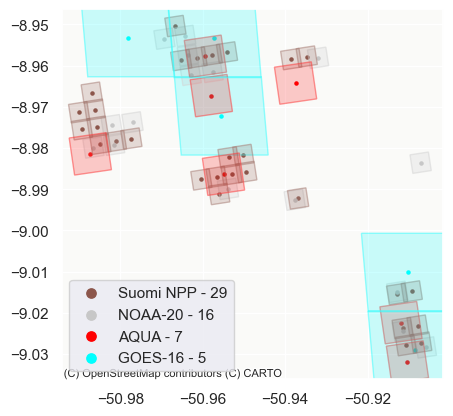

In [583]:
data_temp = sub_space(df.query("'2022-09-02 12:00:00-03:00' < datahora < '2022-09-02 16:00:00-03:00'"), -9.05, -8.95, -51, -50.9)
fig, ax = plt.subplots()
show_satelites_areas(data_temp, ax)


In [550]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from sklearn.cluster import DBSCAN

def show_grid_in_brasil(grid: xarray.DataArray, ax: plt.Axes = None):
    if ax == None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    scale="10m"

    country_border = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_0_boundary_lines_land",
        scale=scale,
        facecolor="none",
    )

    geographic_feature = cfeature.NaturalEarthFeature(
        category="physical",
        name="land",
        scale=scale,
        edgecolor='face',
        facecolor=cfeature.COLORS['land']
    )

    state_border = cfeature.NaturalEarthFeature(
        category="cultural",
        name="admin_1_states_provinces",
        scale=scale,
        facecolor="none",
    )

    #  rect = patches.Rectangle((max_lat, max_lon), max_lon-min_lon, max_lat-min_lat, linewidth=1, edgecolor='r', facecolor='none')
    grid.plot(ax=ax, transform=ccrs.PlateCarree(), zorder=5)
    ax.set_xlim([-70, -35])
    ax.set_ylim([-30, 5])
    ax.add_feature(country_border, edgecolor="black", lw=2, zorder=4)
    ax.add_feature(state_border, edgecolor="black", lw=0.1, zorder=4)
    ax.add_feature(geographic_feature, zorder=3)
    ax.coastlines()
    ax.gridlines(draw_labels=True, zorder=6)

def show_clusters(data: pd.DataFrame, ax: plt.Axes = None, eps: float=0.10):
    if ax == None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    if data.empty:
        return
    min_samples = int(len(data.index) * 0.05)
    clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = clusterer.labels_
    unique_labels = set(labels)

    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[clusterer.core_sample_indices_] = True

    colors = [plt.cm.gist_rainbow(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]
        
        class_member_mask = (labels == k)

        xy = data[class_member_mask & core_samples_mask]
        ax.plot(xy['x'], xy['y'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=5, label=k)

        xy = data[class_member_mask & ~core_samples_mask]
        ax.plot(xy['x'], xy['y'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=3)

    legend = ax.get_legend_handles_labels()
    if legend[1][-1] == '-1':
        legend[1][-1] = 'Ruído'
    ax.add_artist(ax.legend(*legend, loc="lower left", title="Clusters"))

def show_grid(grid: xarray.DataArray, ax: plt.Axes = None): 
    if ax == None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = plt.cm.get_cmap('Reds')
    grid.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    # ax.set_xlim([float(grid.coords['longitude'][0]), float(grid.coords['longitude'][-1])])
    # ax.set_ylim([float(grid.coords['latitude'][0]), float(grid.coords['latitude'][-1])])
    # ax.gridlines(draw_labels=True)

def show_time_grid(data: pd.DataFrame, data_range: pd.DatetimeIndex, 
                   min_lat: float, max_lat: float, min_lon: float, max_lon: float, 
                   columns=2, width=20, clusters: bool = True):
    data_space = sub_space(data, min_lat, max_lat, min_lon, max_lon)
    data_split = split_by_range(data_space, data_range)
    size = len(data_split) + 1
    rows = math.ceil(size/columns)
    print('Ploting with', size, 'Linhas', rows, '...')
    fig, axs = plt.subplots(rows, columns, figsize=(width, int((width-2)/columns) * rows), 
                            subplot_kw={'projection': ccrs.PlateCarree()})
    show_grid_in_brasil(
        xarray.DataArray([[0, 0], [0, 0]], dims=["latitude", "longitude"], coords={"longitude": [min_lon, max_lon], "latitude": [min_lat, max_lat]}), 
        axs.flat[0]
    )
    axs.flat[0].set_title("Brasil")
    for index, ax in enumerate(axs.flat[1:]):
        if index < len(data_split):
            if clusters:
                data_temp = data_split[index].rename(columns={'latitude' : 'y', 'longitude' : 'x'})[['y', 'x']]
                show_clusters(data_temp, ax)
            else:
                grid = compute_grid(data_split[index], min_lat, max_lat, min_lon, max_lon)
                show_grid(grid, ax)
            ax.set_title("{} até {}".format(data_range[index], data_range[index+1]))
            ax.set_xlim([min_lon, max_lon])
            ax.set_ylim([min_lat, max_lat])
            ax.gridlines(draw_labels=True)

    fig.tight_layout(h_pad=0.5, w_pad=0.5)

9


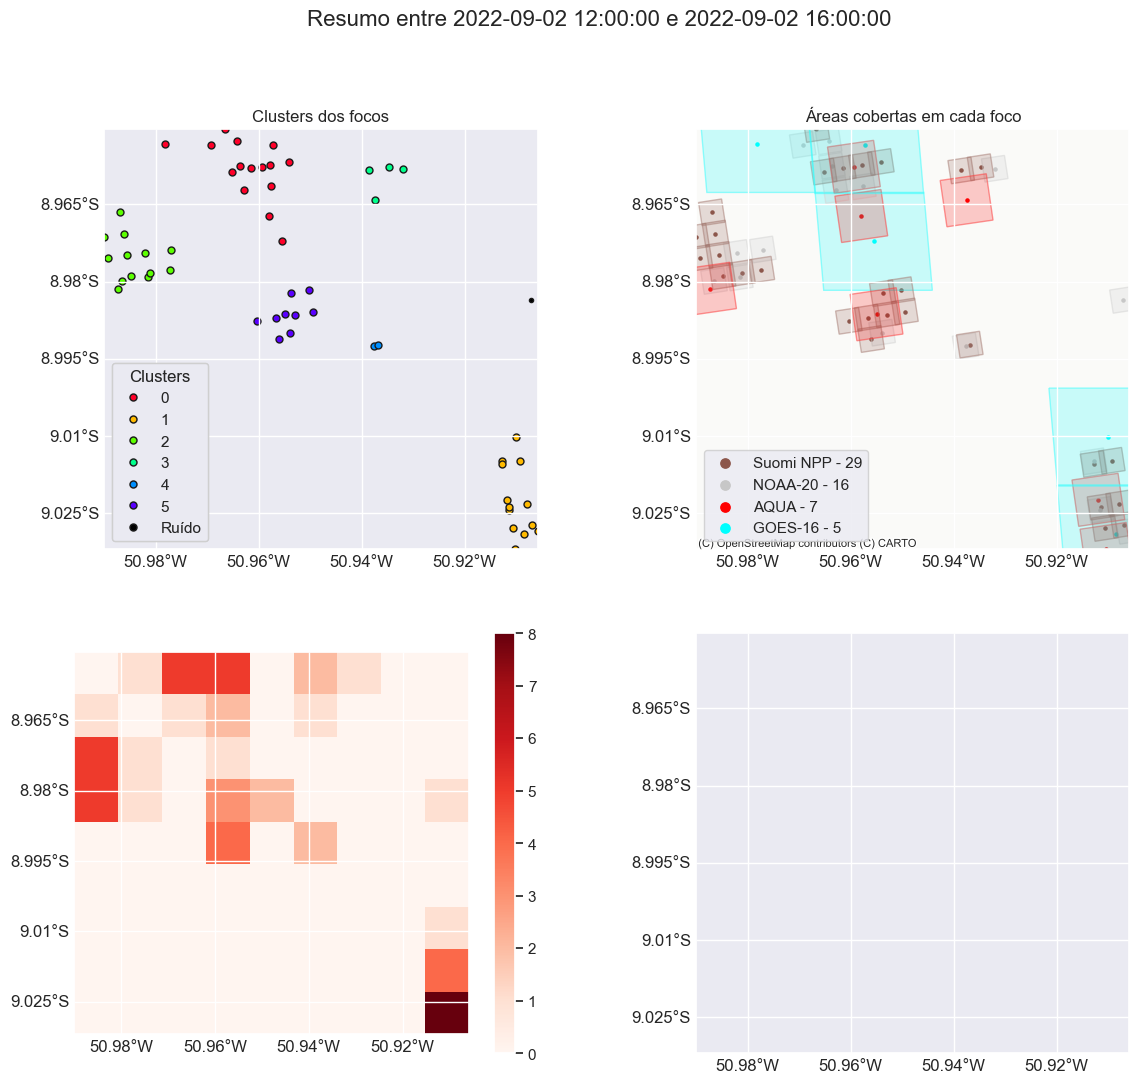

In [584]:
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import Gridliner
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def explore_satelite_data(data: pd.DataFrame, title: str=''):
    min_lat = data['latitude'].min()
    max_lat = data['latitude'].max()
    min_lon = data['longitude'].min()
    max_lon = data['longitude'].max()
    eps = (max_lat - min_lat) / 8

    fig, axs = plt.subplots(2, 2, figsize=(14, 12), layout=None, subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title, fontsize=16)

    axs.flat[0].set_title('Clusters dos focos')
    show_clusters(data.rename(columns={'latitude' : 'y', 'longitude' : 'x'})[['y', 'x']], axs.flat[0], eps=eps)
    
    axs.flat[1].set_title('Áreas cobertas em cada foco')
    show_satelites_areas(data_temp, axs.flat[1])

    axs.flat[2].set_title('Agrupamento simples')
    grid = compute_grid(data)
    show_grid(grid, axs.flat[2])

    fig.tight_layout(pad=0.0)
    for ax in axs.flat:
        ax.set_xlim([min_lon, max_lon])
        ax.set_ylim([min_lat, max_lat])
        ax.label_outer()
        gl: Gridliner = ax.gridlines(draw_labels=True)
        gl.xlocator = mtick.MaxNLocator(5)
        gl.ylocator = mtick.MaxNLocator(6)
        gl.n_steps = 9
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlines = grid.sizes['longitude']
        gl.ylines = grid.sizes['latitude']
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

data_temp = sub_space(df.query("'2022-09-02 12:00:00-03:00' < datahora < '2022-09-02 16:00:00-03:00'"), -9.05, -8.95, -51, -50.9)
explore_satelite_data(data_temp, 'Resumo entre 2022-09-02 12:00:00 e 2022-09-02 16:00:00')

Ploting with 24 Linhas 12 ...
                y         x
38689520 -9.03600 -50.68000
38689550 -9.05500 -50.26500
38689555 -8.65500 -50.68500
38689566 -8.66700 -50.68700
38689573 -8.99700 -50.20000
...           ...       ...
38697851 -8.90200 -50.84500
38697859 -9.37200 -50.70300
38697869 -8.92100 -50.83000
38697878 -9.02000 -50.87900
38698070 -8.86356 -50.86667

[302 rows x 2 columns] 15
                y         x
38698147 -8.90500 -50.85000
38698153 -9.08167 -50.22167
38698163 -9.03167 -50.88500
38698174 -9.02000 -50.76000
38698178 -9.02333 -50.93000
...           ...       ...
38708583 -9.12300 -50.69200
38708608 -9.08021 -50.23333
38708632 -9.19686 -50.00000
38708986 -8.93022 -50.91667
38708989 -9.04688 -50.25000

[370 rows x 2 columns] 18
              y       x
38709572 -9.069 -50.315
38709577 -8.991 -50.738
38709583 -8.998 -50.732
38709595 -9.074 -50.286
38709597 -8.866 -50.865
...         ...     ...
38723411 -8.839 -50.879
38723412 -8.941 -50.886
38723418 -8.955 -50.856
3872

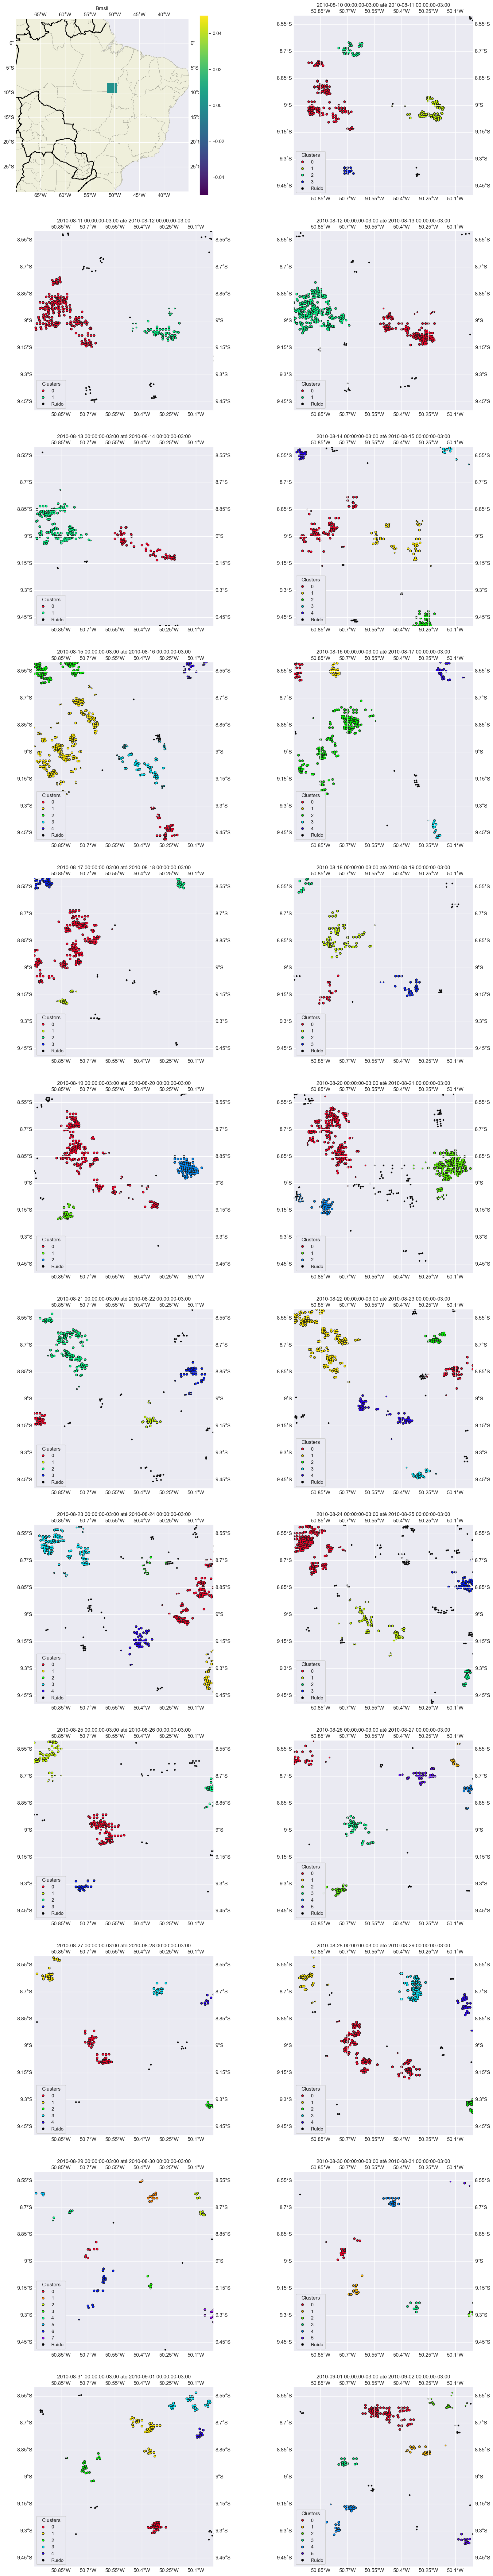

In [544]:
show_time_grid(df, pd.date_range("2010-08-10", freq="1D", periods=25, tz=data_timezone), -9.5, -8.5, -51, -50, clusters=True)

Ploting with 24 Linhas 12 ...


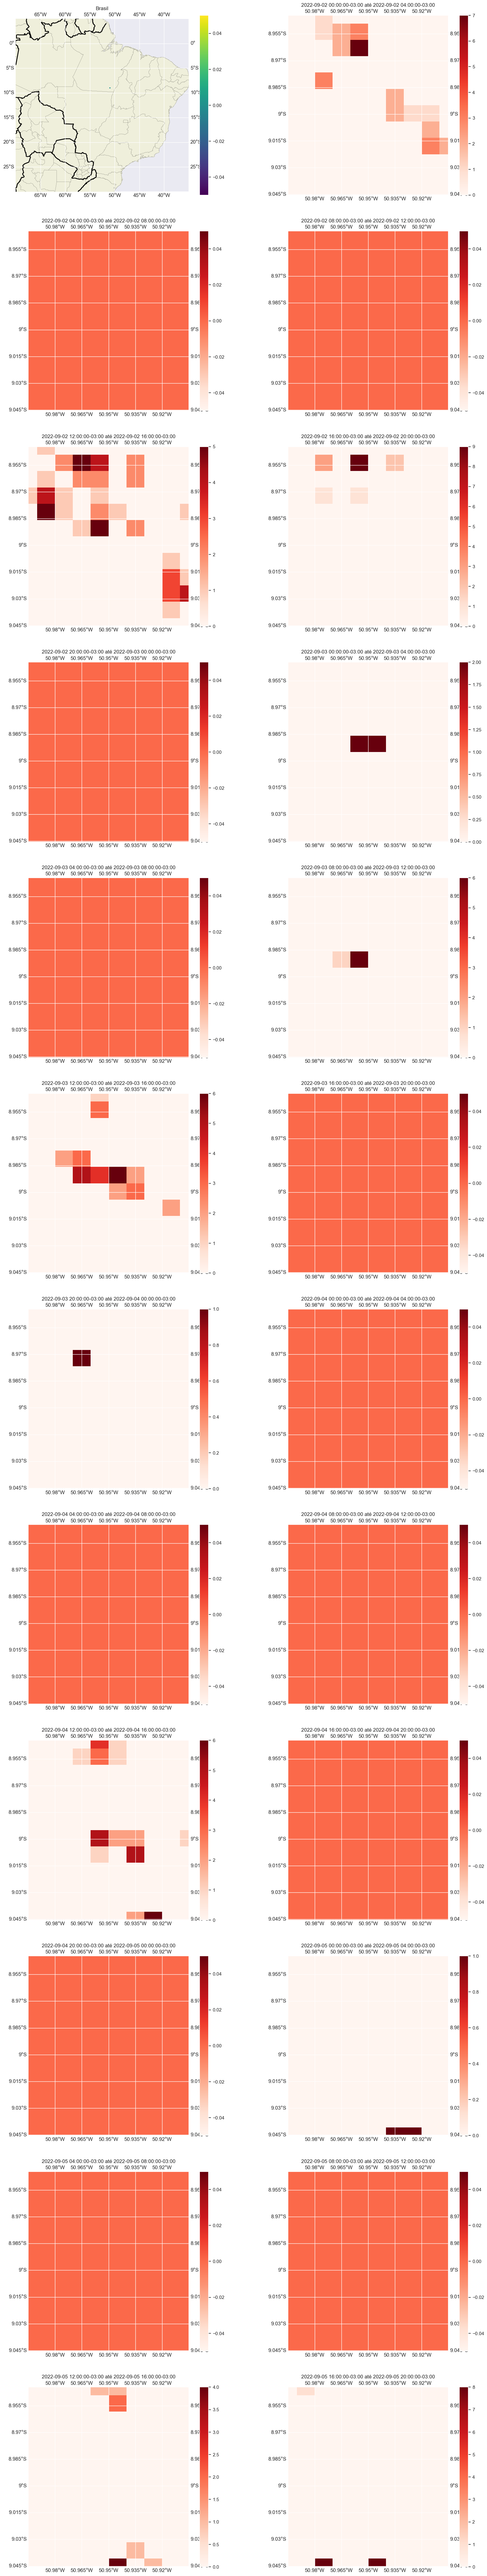

In [446]:
show_time_grid(df, pd.date_range("2022-09-02", freq="4H", periods=25, tz=data_timezone), -9.05, -8.94, -51, -50.9, clusters=False)